# Contour Plot of Prediction of Klein-Gordon Problem

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import numpy as np

In [10]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.utils.plot_prediction import plot_contour
from src.nn.pde import klein_gordon_operator
from src.data.klein_gordon_dataset import u, f

In [11]:
TANH_NORM_DIST = "../../model/a1/klein_tanh_normal_a1.pth"
BSPLINE_DIST = "../../model/a1/klein_bspline_a1.pth"
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "result/klein_gordon")

SOLVER_TO_MODULE = {
    "grbf": "src.nn.grbf",
    "jacobi": "src.nn.jacobi",
    "bspline": "src.nn.bspline",
    "chebyshev": "src.nn.chebyshev",
    "param_tanh": "src.nn.tanh_parameterized",
    "tanh": "src.nn.tanh",
    "fourier": "src.nn.fourier",
}

MODEL_LIST = {
    "tanh": TANH_NORM_DIST,
    "bspline": BSPLINE_DIST,
}

MODEL_DICT = {
    "tanh": [],
    "bspline": [],
}

In [12]:
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

##  Generate Testing Data

In [13]:
# Test data
num_points = 100
# Parameters of equations
alpha = -1.0
beta = 0.0
gamma = 1.0
k = 3

dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])

# Test data
number_of_points = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], number_of_points)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], number_of_points)[:, None]


t_mesh, x_mesh = np.meshgrid(t, x)
X_star = torch.tensor(
    np.hstack((t_mesh.flatten()[:, None], x_mesh.flatten()[:, None])),
    dtype=torch.float32,
).to("cpu")

# Exact solution
u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)

# Load and Test Model

In [14]:
for key, model in MODEL_LIST.items():
    state = torch.load(model)
    config = state.get("config", {})
    solver = config.get("solver")

    # Log model summary and configuration
    logger.print("_summary of the model _")
    logger.print("model path:", model)
    logger.print("model configuration:")
    for k, v in config.items():
        logger.print(f"{k} : {v}")

    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(config.get("network"), config.get("activation")).to("cpu")

    model.load_state_dict(state["model_state_dict"])
    model.eval()

    [u_pred, f_pred] = klein_gordon_operator(model, X_star[:, 0:1], X_star[:, 1:2])

    # Relative L2 error
    error_u = torch.norm(u_pred - u_star, 2) / torch.norm(u_star, 2) * 100
    error_f = torch.norm(f_pred - f_star, 2) / torch.norm(f_star, 2) * 100
    logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
    logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

    MODEL_DICT[key] = [u_pred, f_pred]
    logger.print("***********************************************************")

INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a1/klein_tanh_normal_a1.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 128
INFO:src.utils.logger:network : [2, 30, 30, 30, 1]
INFO:src.utils.logger:weights : [50.0, 50.0, 1.0]
INFO:src.utils.logger:solver : tanh
INFO:src.utils.logger:problem : klein_gordon
INFO:src.utils.logger:dataset_path : None
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 10000
INFO:src.utils.logger:save_every : 10000
INFO:src.utils.logger:loss_list : ['lbcs', 'linitial', 'lphy']
INFO:src.utils.logger:log_path : /home/vlq26735/afrah/code/pinn_learnable_activation/checkpoints/klein
INFO:src.utils.logger:Relative L2 error_u: 1.59e+00
INFO:src.utils.logger:Relative L2 error_f: 4.94e-01
INFO:src.utils.logger:***********************************************************
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model 

## Plot Test Result

Reshape results and plot

In [15]:
X = np.concatenate([t, x], axis=1)
u = u_star.cpu().detach().numpy()
u_pred_tanh = MODEL_DICT["tanh"][0].cpu().detach().numpy()
u_pred_bspline = MODEL_DICT["bspline"][0].cpu().detach().numpy()

In [16]:
X.shape

(100, 2)

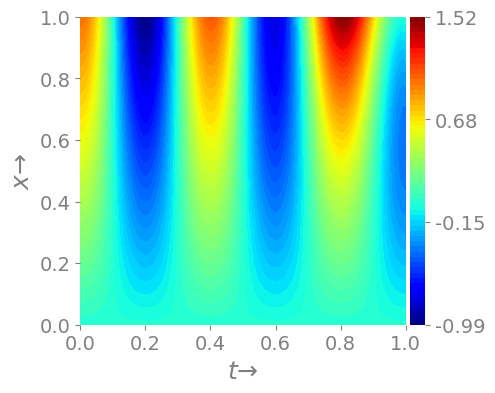

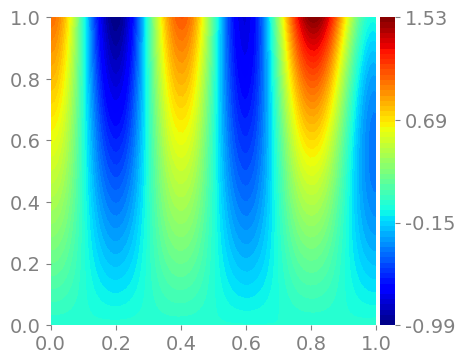

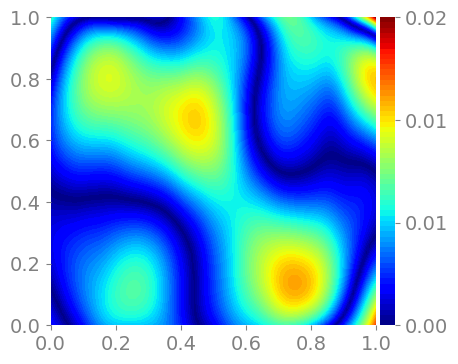

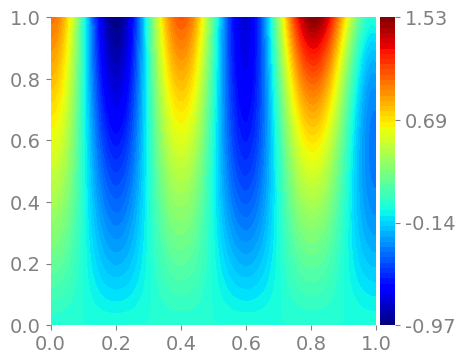

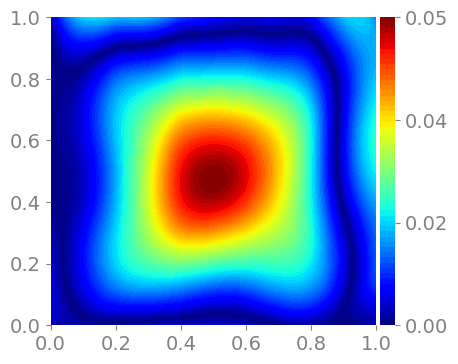

In [18]:
exact_veloctiy_klein = u
tanh_veloctiy_u_klein = u_pred_tanh
tanh_error_veloctiy_klein = np.abs(u_pred_tanh - u)
bspline_veloctiy_klein = u_pred_bspline
bspline_error_veloctiy_klein = np.abs(u_pred_bspline - u)


data = [
    exact_veloctiy_klein,
    tanh_veloctiy_u_klein,
    tanh_error_veloctiy_klein,
    bspline_veloctiy_klein,
    bspline_error_veloctiy_klein,
]

titles = [
    "exact_veloctiy_klein",
    "tanh_veloctiy_u_klein",
    "tanh_error_veloctiy_klein",
    "bspline_veloctiy_klein",
    "bspline_error_veloctiy_klein",
]
xy_labels = [r"$t→$", r"$x→$"]

for index, (title, z) in enumerate(zip(titles, data)):
    file_name = os.path.join(model_dirname, f"{title}.png")
    plot_xy = index == 0
    fig = plot_contour(X, z.reshape(100, 100), file_name, plot_xy, xy_labels)